In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py, yaml, os, psutil

import tensorflow as tf
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from msfm.fiducial_pipeline import FiducialPipeline
from msfm.utils import files, parameters, logger

from deep_lss.models.delta_model import DeltaLossModel
from deep_lss.nets import resnet
from deep_lss.utils import configuration

LOGGER = logger.get_logger("temp")

24-02-29 02:12:58   imports.py INF   Setting up healpy to run on 32 CPUs 
24-02-29 02:12:59   imports.py INF   Setting up healpy to run on 32 CPUs 


In [3]:
def get_ram_usage():
    process = psutil.Process()
    mem_info = process.memory_info()
    ram_gb = mem_info.rss / (1024 ** 3)
    
    return ram_gb

In [4]:
tfr_pattern = "/pscratch/sd/a/athomsen/DESY3/v7/linear_bias/tfrecords/fiducial/validation/DESy3_fiducial_????.tfrecord"

conf = "//global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v7/linear_bias.yaml"
params = ["Om", "s8", "w0", "Aia", "n_Aia"]

In [5]:
fidu_pipe = FiducialPipeline(
    conf=conf,
    params=params,
    with_lensing=True,
    with_clustering=False,
    with_padding=True,
    apply_norm=True,
)

fidu_dset = fidu_pipe.get_dset(
    tfr_pattern=tfr_pattern,
    local_batch_size=4,
    n_noise=3,
    n_readers=1,
    is_eval=True,
    n_prefetch=1,
)

24-02-29 02:13:01     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_512.h5 
24-02-29 02:13:01     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_512.h5 
24-02-29 02:13:03 fiducial_pip WAR   Evaluation mode is activated: the random seed is fixed, the shuffle arguments ignored, and the dataset is not repeated 
24-02-29 02:13:03 fiducial_pip INF   Interleaving with n_readers = 1 


/global/common/software/des/athomsen/dlss/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:2210: UserWarning: The `deterministic` argument has no effect unless the `num_parallel_calls` argument is specified.
  warnings.warn("The `deterministic` argument has no effect unless the "


24-02-29 02:13:03 fiducial_pip INF   Batching into 4 elements locally 
24-02-29 02:13:04 fiducial_pip WAR   Tracing _augmentations 
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
24-02-29 02:13:05 fiducial_pip INF   Running on the data_vectors.keys() = dict_keys(['kg_fiducial', 'kg_delta_Om_m', 'kg_delta

# dataset only

In [6]:
# ram_usage = []
# for i in LOGGER.progressbar(range(30)):
#     ram = get_ram_usage()
#     ram_usage.append(ram)
#     LOGGER.info(f"iteration {i}, ram = {ram:.3} GB")
    
#     for _, _ in fidu_dset:
#         pass
    
# fig, ax = plt.subplots()
# ax.plot(ram_usage)

# model

In [7]:
n_side = 512
data_vec_pix = fidu_pipe.data_vec_pix
n_z_bins = 4
n_params= len(params)
local_batch_size = 16
perts = parameters.get_fiducial_perturbations(params, conf)

base_dir = "/pscratch/sd/a/athomsen/run_files/v7/lensing"
model_dir = os.path.join(base_dir, "delta/2024-02-22_03-37-44_resnet_vanilla")

with open(os.path.join(model_dir, "configs.yaml"), "r") as f:
    net_conf, dlss_conf, msfm_conf = list(yaml.load_all(f, Loader=yaml.FullLoader))

In [8]:
smoothing_kwargs = configuration.get_smoothing_kwargs(
    "delta", msfm_conf, dlss_conf, net_conf, dir_base=base_dir
)

network = resnet.ResNetLayers(
    out_dim=n_params, smoothing_kwargs=smoothing_kwargs, **net_conf["network"]["kwargs"]
).get_layers()

model = DeltaLossModel(
    network=network,
    n_side=n_side,
    indices=data_vec_pix,
    n_neighbors=net_conf["network"]["n_neighbors"],
    checkpoint_dir=os.path.join(model_dir, "checkpoint"),
    max_batch_size=(2*n_params+1)*local_batch_size,
    input_shape=(None, len(data_vec_pix), n_z_bins),
    restore_checkpoint=True,
    strategy=None,
)

model.setup_delta_loss_step(
    n_params,
    local_batch_size,
    perts,
    n_channels=n_z_bins,
    **dlss_conf["delta_loss"],
    **net_conf["optimization"]["gradient_clipping"],
)

24-02-29 02:13:06     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_512.h5 
24-02-29 02:13:06     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_512.h5 
Using the per channel smoothing repetitions [6 3 2 1]
Using the per channel smoothing scales sigma = [9.78 6.91 5.65 3.99] arcmin, fwhm = [23.03 16.28 13.29  9.4 ] arcmin
Successfully loaded sparse kernel indices and values from /pscratch/sd/a/athomsen/run_files/v7/lensing/smoothing
Successfully created the sparse kernel tensor
24-02-29 02:13:06 base_model.p INF   Initializing with a HealpyGCNN model 
Detected a reduction factor of 32.0, the input with nside 512 will be transformed to 16 during a forward pass. Checking for consistency with indices...
indices seem consistent...
Successfully built the smoothing layer
Tracing... Due to tensor size, tf.sparse.sparse_dense_matmul is executed over 2 splits. Bew

  0%|                            |   | 0/30 [00:00<?, ?it/s]                  24-02-29 02:13:08         temp INF   iteration 0, ram = 3.94 GB 
  3%|▉                           |   | 1/30 [00:24<11:53, 24.61s/it]          24-02-29 02:13:33         temp INF   iteration 1, ram = 9.46 GB 
  7%|█▊                          |   | 2/30 [00:46<10:43, 22.97s/it]          24-02-29 02:13:55         temp INF   iteration 2, ram = 10.4 GB 
 10%|██▊                         |   | 3/30 [01:08<10:06, 22.47s/it]          24-02-29 02:14:17         temp INF   iteration 3, ram = 10.7 GB 
 13%|███▋                        |   | 4/30 [01:30<09:37, 22.22s/it]          24-02-29 02:14:38         temp INF   iteration 4, ram = 11.5 GB 
 17%|████▋                       |   | 5/30 [01:52<09:14, 22.18s/it]          24-02-29 02:15:01         temp INF   iteration 5, ram = 11.4 GB 
 20%|█████▌                      |   | 6/30 [02:14<08:52, 22.19s/it]          24-02-29 02:15:23         temp INF   iteration 6, ram = 11.1 GB 

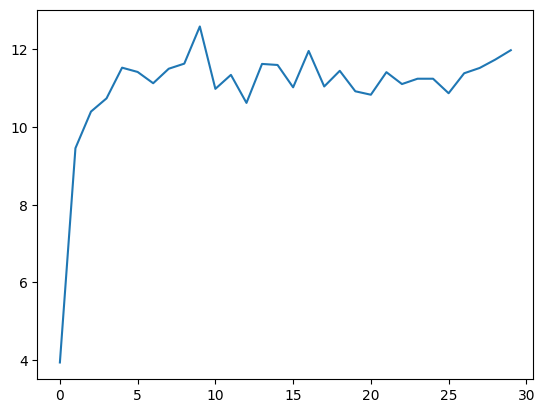

In [9]:
ram_usage = []
for i in LOGGER.progressbar(range(30)):
    ram = get_ram_usage()
    ram_usage.append(ram)
    LOGGER.info(f"iteration {i}, ram = {ram:.3} GB")
    
    for batch, _ in fidu_dset:
        model(batch)
    
fig, ax = plt.subplots()
ax.plot(ram_usage)